In [2]:
import sys
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
os.listdir()

['func_for_tf_img_classification.ipynb',
 'russian_toxic_comments.ipynb',
 'test_tf_NLP.ipynb',
 'tf_image_classification.ipynb',
 'tf_NLP.ipynb',
 'tf_regression.ipynb']

In [4]:
batch_size = 32
seed=42

In [5]:
train_data_path = fr'C:\ML\DataBases\train_eng_NLP'
test_data_path = fr'C:\ML\DataBases\test_eng_NLP'

In [6]:
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_data_path,
    batch_size=batch_size,
    validation_split = 0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_data_path, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
for batch, label in raw_train_ds.take(1):
    for i in range(3):
        print(len(label), batch)

32 tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into compli

In [9]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_data_path, 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [10]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
embedding_dim = 32

In [44]:
model = tf.keras.Sequential()
model.add(layers.Embedding(max_features + 1, embedding_dim))
model.add(layers.Dropout(0.1))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

In [45]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          320032    
                                                                 
 dropout_6 (Dropout)         (None, None, 32)          0         
                                                                 
 global_average_pooling1d_7  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 320065 (1.22 MB)
Trainable params: 320065 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [19]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.9)])

In [20]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.008, patience=3, verbose=4)]

In [21]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=20,
    callbacks = callbacks
)

Epoch 1/20
625/625 [==============================] - 10s 15ms/step - loss: 0.4883 - binary_accuracy: 0.6718 - val_loss: 0.3245 - val_binary_accuracy: 0.8194
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2714 - binary_accuracy: 0.8687 - val_loss: 0.2894 - val_binary_accuracy: 0.8532
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2146 - binary_accuracy: 0.9017 - val_loss: 0.2867 - val_binary_accuracy: 0.8592
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1815 - binary_accuracy: 0.9199 - val_loss: 0.2944 - val_binary_accuracy: 0.8618
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1522 - binary_accuracy: 0.9330 - val_loss: 0.3105 - val_binary_accuracy: 0.8670
Epoch 5: early stopping


In [22]:
loss, accuracy = model.evaluate(test_ds)
print(loss,accuracy)

782/782 [==============================] - 16s 20ms/step - loss: 0.3515 - binary_accuracy: 0.8503
0.35151538252830505 0.8502799868583679


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

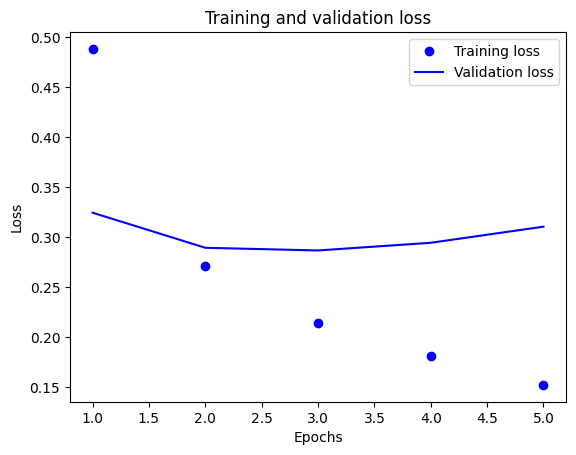

In [24]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

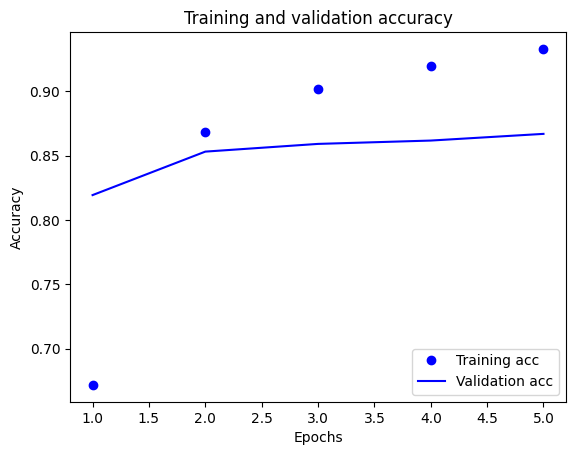

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [26]:
def vectorize_t(text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)

In [35]:
text_list = ['hi world my name is egor',
             'i fuck your mom',
             'i am a genius man',
             'Fuck you motherfucker']

text = vectorize_t(text_list)

In [36]:
y_pred = model.predict(text)
print(y_pred)
np.round(y_pred, 0)

1/1 [==============================] - 0s 31ms/step
[[ 0.30315238]
 [-0.12236346]
 [ 0.2991355 ]
 [ 0.10950816]]


array([[ 0.],
       [-0.],
       [ 0.],
       [ 0.]], dtype=float32)